Diagnosis of Presence of Heart Disease Based on Age, Chest Pain Type, Cholesterol, Resting Blood Pressure

Names: Srijan Sanghera, Sharon Feng

Introduction

Exploratory Analysis

In [28]:
library(tidyverse)
library(tidymodels)

URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
heart <- read_delim(URL, delim = ",", col_names = FALSE) |>
        rename(age = X1, sex = X2, cp = X3, trestbps = X4, chol = X5, fbs = X6, restecg = X7, thalach = X8, exang = X9,
               oldpeak = X10, slope = X11, ca = X12, thal = X13, num_predicted = X14)
heart

heart_data <- heart |>
    select(age, cp, chol, trestbps, num_predicted) |>
    filter(cp != "?", chol != "?", trestbps != "?")

heart_data
#split data into training and testing
heart_split <- initial_split(heart_data, prop = 0.75, strata = num_predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_predicted
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0
32,1,2,110,225,0,0,184,0,0,?,?,?,0
32,1,2,125,254,0,0,155,0,0,?,?,?,0
33,1,3,120,298,0,0,185,0,0,?,?,?,0


age,cp,chol,trestbps,num_predicted
<dbl>,<dbl>,<chr>,<chr>,<dbl>
28,2,132,130,0
29,2,243,120,0
30,1,237,170,0
31,2,219,100,0
32,2,198,105,0
32,2,225,110,0
32,2,254,125,0
33,3,298,120,0
34,2,161,130,0


Methods

Expected outcomes and significance

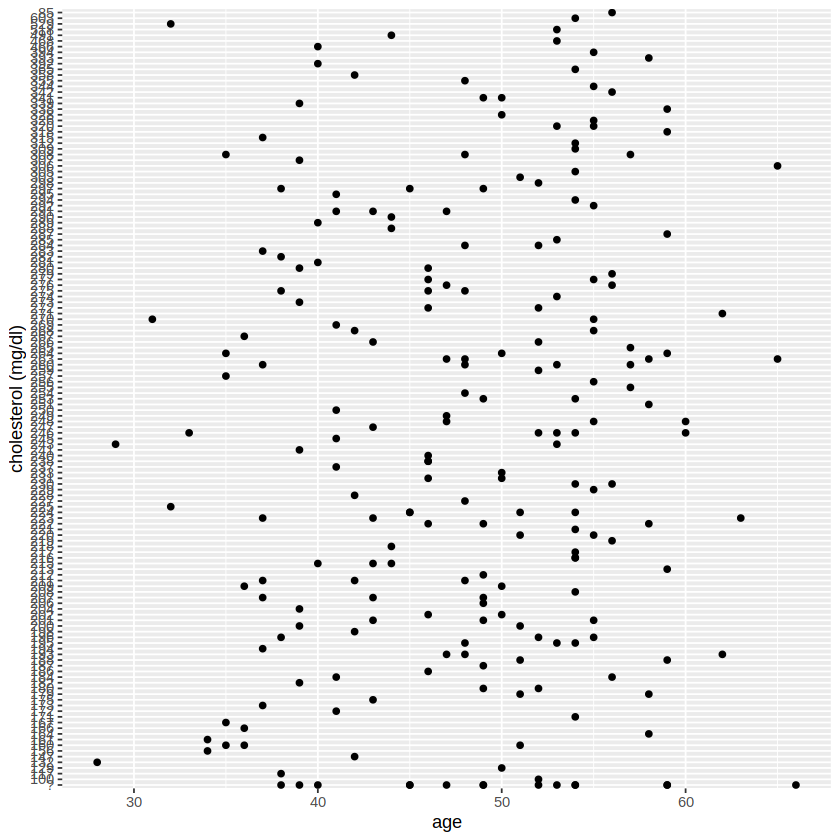

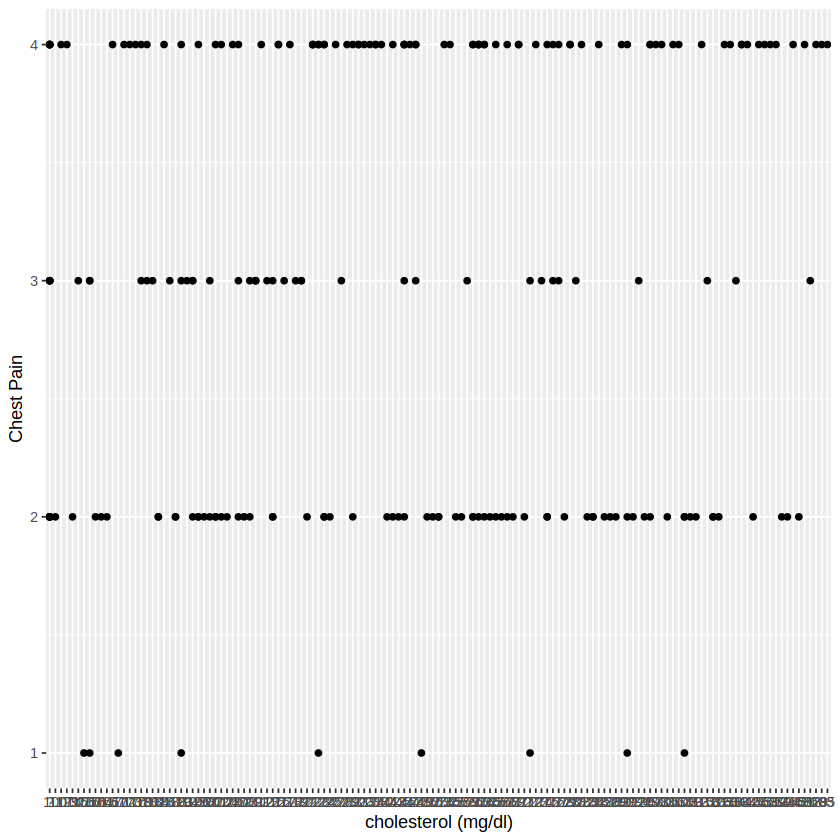

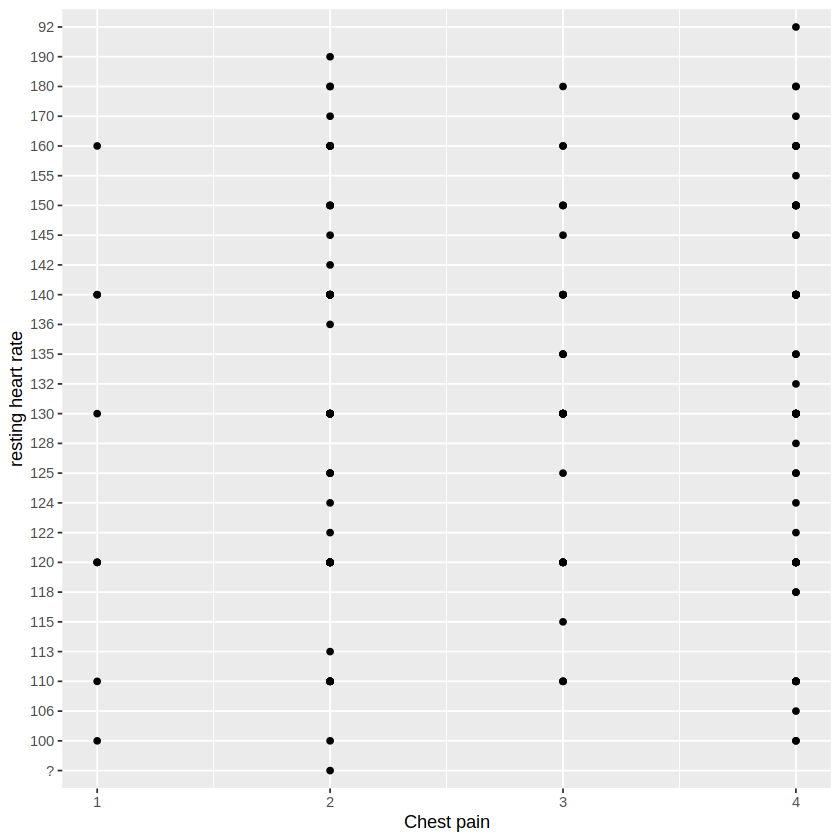

In [14]:
#visualising trainin data
plot_1 <- ggplot(heart_train,aes(x = age, y = chol)) +
                 geom_point() +
                 labs(x = " age ", y = "cholesterol (mg/dl)") +
                 scale_color_brewer(palette = "Set2")

plot_1

plot_2 <- ggplot(heart_train,aes(x = chol, y = cp)) +
                 geom_point() +
                 labs(x = " cholesterol (mg/dl) ", y = "Chest Pain") +
                 scale_color_brewer(palette = "Set2")

plot_2

plot_3 <- ggplot(heart_train,aes(x = cp, y = trestbps)) +
                 geom_point() +
                 labs(x = " Chest pain ", y = "resting heart rate") +
                 scale_color_brewer(palette = "Set2")

plot_3